In [1]:
import pandas as pd

df = pd.read_csv('disease.csv')
print(df.head())


        disease                                           symptoms  \
0           flu  fever,cough,sore throat,runny or stuffy nose,m...   
1    bronchitis  cough,mucus production,shortness of breath,che...   
2     pneumonia  fever,cough,shortness of breath,chest pain,fat...   
3  heart attack  chest pain,shortness of breath,nausea,vomiting...   
4        stroke  sudden weakness,numbness on one side of the bo...   

                                               cures  \
0           over-the-counter medications,rest,fluids   
1  antibiotics,over-the-counter medications,rest,...   
2  antibiotics,over-the-counter medications,rest,...   
3                         emergency medical services   
4                         emergency medical services   

                        doctor     risk level  
0    family doctor,urgent care      low (0.1%  
1  family doctor,pulmonologist      low (0.5%  
2  family doctor,pulmonologist  moderate (1%)  
3                 cardiologist     high (20%)  
4 

In [5]:
#data cleaning
import re
df['risk_percentage'] = df['risk level'].apply(lambda x: float(re.findall(r"\d+\.?\d*", x)[0]) if re.findall(r"\d+\.?\d*", x) else None)

print(df[['risk level', 'risk_percentage']].head())


      risk level  risk_percentage
0      low (0.1%              0.1
1      low (0.5%              0.5
2  moderate (1%)              1.0
3     high (20%)             20.0
4     high (15%)             15.0


In [7]:
#feature encoding
from sklearn.preprocessing import MultiLabelBinarizer

df['symptoms'] = df['symptoms'].apply(lambda x: x.split(','))
df['doctor'] = df['doctor'].apply(lambda x: x.split(','))

mlb_symptoms = MultiLabelBinarizer()
mlb_doctor = MultiLabelBinarizer()

symptoms_encoded = pd.DataFrame(mlb_symptoms.fit_transform(df['symptoms']), columns=mlb_symptoms.classes_)
doctor_encoded = pd.DataFrame(mlb_doctor.fit_transform(df['doctor']), columns=mlb_doctor.classes_)

df_encoded = pd.concat([df, symptoms_encoded, doctor_encoded], axis=1)
df_encoded.drop(columns=['symptoms', 'doctor', 'risk level'], inplace=True)
print(df_encoded.head())


        disease                                              cures  \
0           flu           over-the-counter medications,rest,fluids   
1    bronchitis  antibiotics,over-the-counter medications,rest,...   
2     pneumonia  antibiotics,over-the-counter medications,rest,...   
3  heart attack                         emergency medical services   
4        stroke                         emergency medical services   

   risk_percentage  abdominal cramps  abdominal pain  \
0              0.1                 0               0   
1              0.5                 0               0   
2              1.0                 0               0   
3             20.0                 0               0   
4             15.0                 0               0   

   abnormal pap test results  abnormal vaginal bleeding  aerophobia  \
0                          0                          0           0   
1                          0                          0           0   
2                          0 

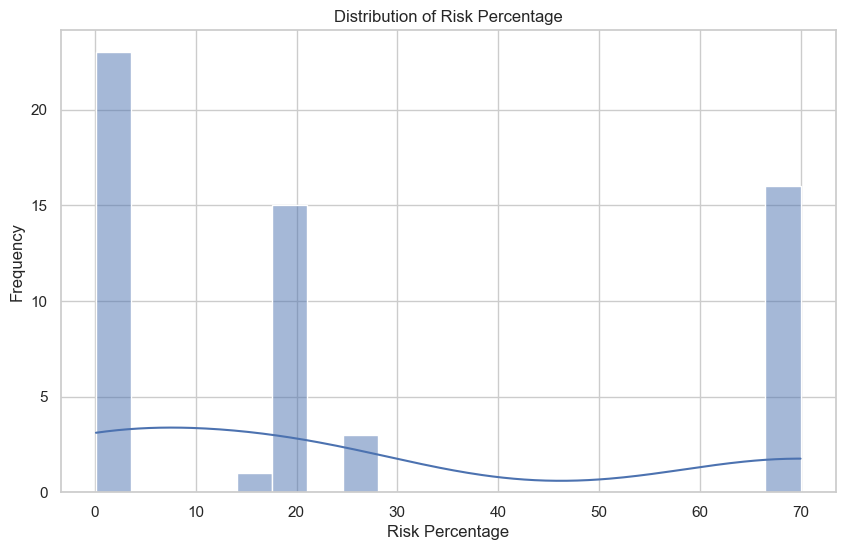

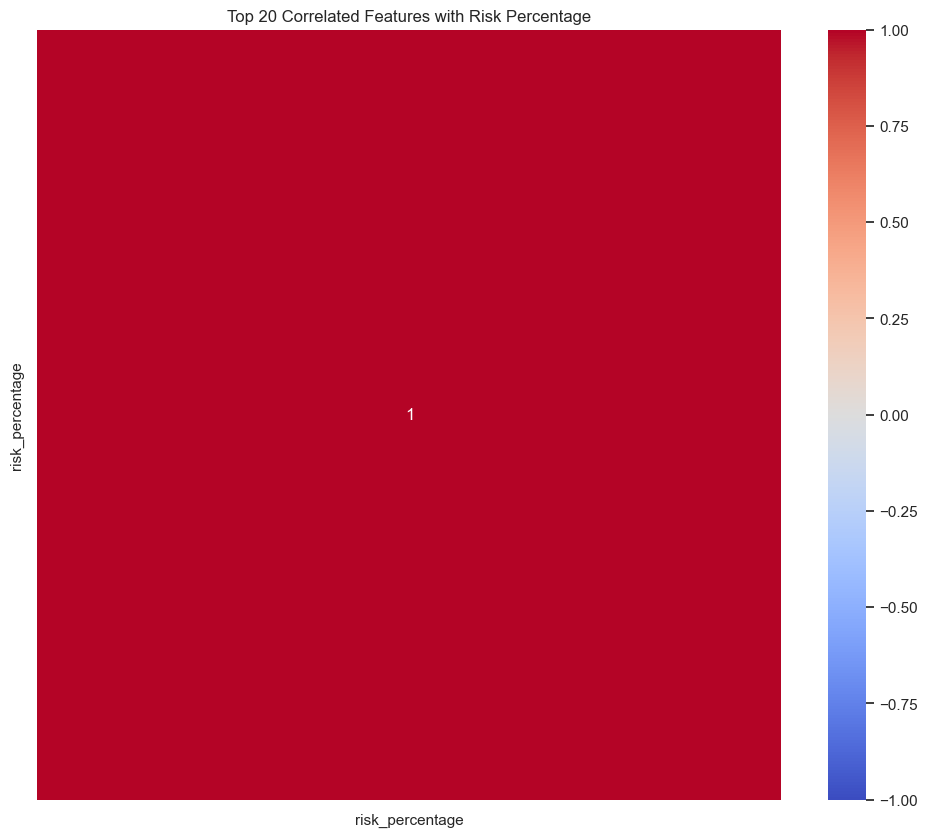

In [13]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_encoded['risk_percentage'], kde=True, bins=20)
plt.title('Distribution of Risk Percentage')
plt.xlabel('Risk Percentage')
plt.ylabel('Frequency')
plt.show()

numeric_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_encoded[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['risk_percentage']].sort_values(by='risk_percentage', ascending=False).head(20), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 20 Correlated Features with Risk Percentage')
plt.show()


In [17]:
#using Support Vector Machine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

df_encoded['risk_percentage'].fillna(df_encoded['risk_percentage'].mean(), inplace=True)

X = df_encoded.drop(columns=['disease', 'cures', 'risk_percentage'])
y = df_encoded['risk_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 433.0836383574756
R^2 Score: 0.010643930876973351
